### Import libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pointbiserialr

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_theme(style="whitegrid", palette="pastel")

### Read dataframes

In [2]:
df = pd.read_csv('data/train_set.csv')

input_file = "data/numerical_features.json"

with open(input_file, 'r') as f:
    continuous_features = json.load(f)

In [3]:
# Keep only continuous variables and the flag
df_continuous = df[continuous_features + ['payment_delay']].copy()

### Compute VIF

In [4]:
# Create a df storing only the continuous features
X = df_continuous.drop('payment_delay', axis=1).copy()

removed_variables = pd.DataFrame(columns=["variables", "VIF"])

# Define a flag variable
high_vif = True

while high_vif:
    # Calculate VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # If the maximum VIF is greater than 15, remove a variable with the highest VIF
    if vif["VIF"].max() > 15:
        # Identify the variable with the highest VIF
        removed_variable = vif.loc[vif["VIF"].idxmax()]
        # Store the removed variable
        removed_variables = pd.concat([removed_variables, pd.DataFrame([removed_variable])], ignore_index=True)
        # Drop the variable with the highest VIF from X
        X = X.drop(columns = [removed_variable["variables"]])
    else:
        high_vif = False
        
df_vif = pd.concat([vif, removed_variables]).sort_values('VIF', ascending=False).reset_index(drop=True)
df_vif.to_csv('data/vif.csv', index=False)

### Correlation matrix

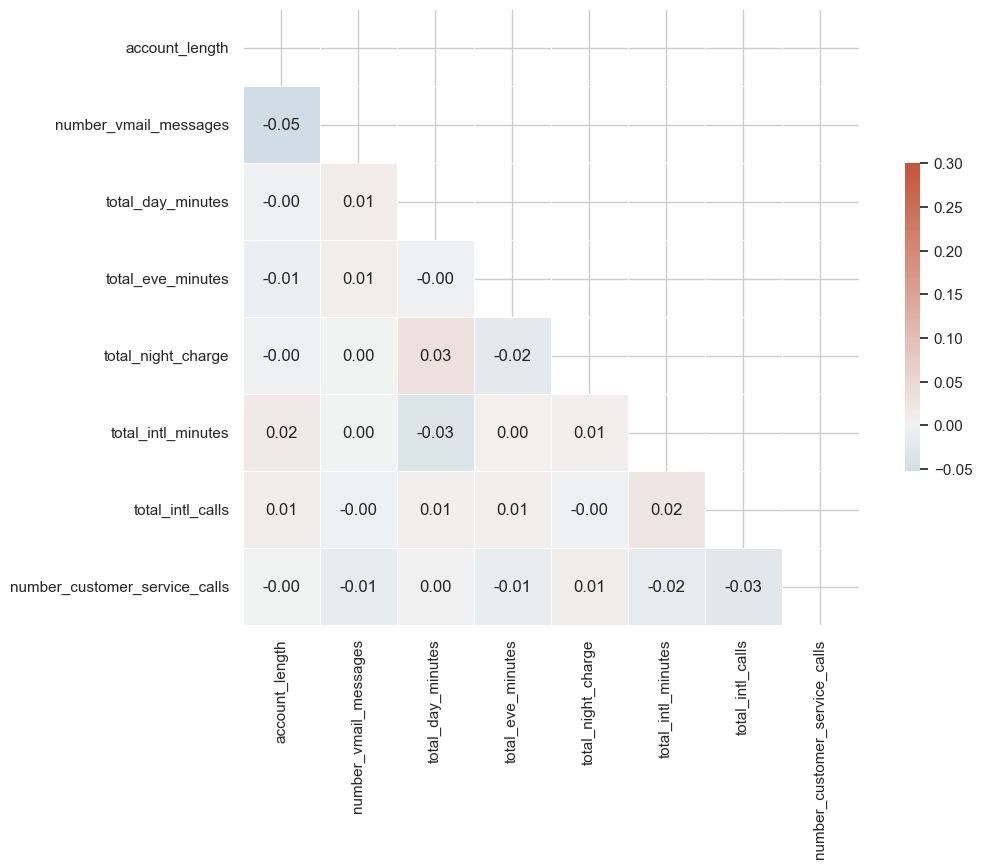

In [5]:
correlation_matrix = X.corr(numeric_only=True)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(12, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
plt.show()

### Correlation with dependent variable

In [6]:
after_vif_vars = vif.variables.to_list()
results = []

for col in df_continuous[after_vif_vars].columns:  
    pbc = pointbiserialr(df_continuous[col], df_continuous['payment_delay'])
    results.append({'Variable': col, 'Correlation': pbc.correlation})

corr_df = pd.DataFrame(results)
corr_df = corr_df.sort_values('Correlation', ascending=False).reset_index(drop=True)
corr_df

,Variable,Correlation
0,total_day_minutes,0.215
1,number_customer_service_calls,0.202
2,total_eve_minutes,0.089
3,total_intl_minutes,0.069
4,total_night_charge,0.041
5,account_length,0.033
6,total_intl_calls,-0.034
7,number_vmail_messages,-0.098
